In [80]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
from glob import glob 
import pandas as pd 
from pathlib import Path 
import os

from fastcore.xtras import load_pickle
from scipy.stats import sem

from gptchem.plotsettings import *
from gptchem.settings import (
    ONE_COL_GOLDEN_RATIO_HEIGHT_INCH,
    ONE_COL_WIDTH_INCH,
    TWO_COL_GOLDEN_RATIO_HEIGHT_INCH,
)

%matplotlib inline

In [82]:
res = glob('results_new2/*.pkl')

In [91]:
loaded_res = []
bv_res = []
oximachine_res = []
for r in res:
    loaded = load_pickle(r)
    if loaded['balanced']:
        continue
    if loaded['train_size'] >= 7000:
        continue
    res_gpt = {
        'train_size': loaded['train_size'],
        'accuracy': loaded['accuracy'],
        'f1_macro': loaded['f1_macro'],
        'f1_micro': loaded['f1_micro'],
        'kappa': loaded['kappa'],
    }

    res_bv = {
        'train_size': loaded['train_size'],
        'accuracy': loaded['bv']['accuracy'],
        'f1_macro': loaded['bv']['f1_macro'],
        'f1_micro': loaded['bv']['f1_micro'],
        'kappa': loaded['bv']['kappa'],
    }

    res_oximachine = {
        'train_size': loaded['train_size'],
        'accuracy': loaded['oximachine']['accuracy'],
        'f1_macro': loaded['oximachine']['f1_macro'],
        'f1_micro': loaded['oximachine']['f1_micro'],
        'kappa': loaded['oximachine']['kappa'],
    }

    loaded_res.append(res_gpt)
    bv_res.append(res_bv)
    oximachine_res.append(res_oximachine)
    

In [92]:
loaded_res = pd.DataFrame(loaded_res)
bv_res = pd.DataFrame(bv_res)
oximachine_res = pd.DataFrame(oximachine_res)

In [93]:
loaded_res_grouped = loaded_res.groupby('train_size').agg(['mean', 'std', sem, 'count'])

In [94]:
loaded_res_grouped

accuracy                            f1_macro                      \
                mean       std       sem count      mean       std       sem   
train_size                                                                     
10          0.756250  0.017500  0.008750     4  0.430562  0.005731  0.002866   
50          0.815000  0.037193  0.018597     4  0.638537  0.145447  0.072724   
200         0.843750  0.031192  0.015596     4  0.777258  0.044489  0.022244   
500         0.865000  0.010000  0.005774     3  0.806049  0.009816  0.005667   
1000        0.870000  0.017321  0.010000     3  0.810840  0.031967  0.018456   
4000        0.915000  0.026771  0.013385     4  0.874291  0.042768  0.021384   
5000        0.915000  0.042426  0.030000     2  0.882528  0.061721  0.043644   
6000        0.929167  0.022230  0.009075     6  0.900967  0.032598  0.013308   

                  f1_micro                               kappa            \
           count      mean       std       sem count      mean       std   
train_size                                                                 
10             4  0.756250  0.017500  0.008750     4 -0.016220  0.032439   
50             4  0.815000  0.037193  0.018597     4  0.323246  0.232363   
200            4  0.843750  0.031192  0.015596     4  0.554709  0.088915   
500            3  0.865000  0.010000  0.005774     3  0.612440  0.019951   
1000           3  0.870000  0.017321  0.010000     3  0.622328  0.063022   
4000           4  0.915000  0.026771  0.013385     4  0.749230  0.084886   
5000           2  0.915000  0.042426  0.030000     2  0.765124  0.123522   
6000           6  0.929167  0.022230  0.009075     6  0.802034  0.065198   

                            
                 sem count  
train_size                  
10          0.016220     4  
50          0.116181     4  
200         0.044458     4  
500         0.011519     3  
1000        0.036386     3  
4000        0.042443     4  
5000        0.087343     2  
6000        0.026617     6

/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/src/gptchem/plotutils.py:12: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(x_min - pad * (x_max - x_min), x_max + pad * (x_max - x_min))


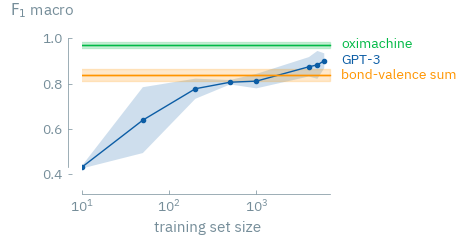

In [95]:
fig, ax = plt.subplots(1, 1, figsize=(ONE_COL_WIDTH_INCH, ONE_COL_GOLDEN_RATIO_HEIGHT_INCH))

metric = 'f1_macro'
error = 'std'
ax.plot(
    loaded_res_grouped.index,
    loaded_res_grouped[metric]['mean'],
    marker='o',
    label='GPT-3',
)
ax.fill_between(
    loaded_res_grouped.index,
    loaded_res_grouped[metric]['mean'] - loaded_res_grouped[metric][error],
    loaded_res_grouped[metric]['mean'] + loaded_res_grouped[metric][error],
    alpha=0.2,
)

ax.hlines(
    oximachine_res[metric].mean(),
    0,  
    7000,
    label='oximachine',
    color='C1'
)
# plot this also to have a legend
ax.plot(
    [0, 7000],
    [oximachine_res[metric].mean(), oximachine_res[metric].mean()],
    color='C1',
    label='oximachine',
)
ax.fill_between(
    [0, 7000],
    oximachine_res[metric].mean() - oximachine_res[metric].std(),
    oximachine_res[metric].mean() + oximachine_res[metric].std(),
    alpha=0.2,
    color='C1'
)

ax.hlines(
    bv_res[metric].mean(),
    0,
    7000,
    label='bond-valence sum',
    color='C2'
)
# plot this also to have a legend
ax.plot(
    [0, 7000],
    [bv_res[metric].mean(), bv_res[metric].mean()],
    color='C2',
    label='bond-valence sum',
)
ax.fill_between(
    [0, 7000],
    bv_res[metric].mean() - bv_res[metric].std(),
    bv_res[metric].mean() + bv_res[metric].std(),
    alpha=0.2,
    color='C2',
    label='bond-valence sum',
)
ax.set_xscale('log')

range_frame(
    ax, 
    np.array([10, 7000]),
    np.array([loaded_res_grouped[metric]['mean'].min(), oximachine_res[metric].max()]),
)

ax.set_xlabel('training set size')
ylabel_top(r'$\mathrm{F}_1$ macro')

matplotx.line_labels(ax)

fig.savefig('f1_macro.pdf', bbox_inches='tight')